In [1]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# defining function for dataLoading function
framObjTrain = {'img' : [],    #defines a dictionary in Python, named framObjTrain. The dictionary has two keys: 'img' and 'mask'
           'mask' : []         #The values for both keys are empty lists ([]) initially. used as a container for storing preprocessed image and mask data.
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128): #This function is designed to load images and corresponding masks from specified directories, resize them to a uniform shape, and store the processed data in the frameObj dictionary.

    imgNames = os.listdir(imgPath) #Retrieves a list of all file names in the directory specified by imgPath
    maskNames = [] #Initializes an empty list to store the base names (identifiers) of the image-mask pairs. 
                   #These base names will be extracted from the image file names.
    
    ## generating mask names
    for mem in imgNames: #To extract the unique base names (identifiers) from the image filenames and store them in maskNames.
        mem = mem.split('_')[0] #Splits the filename mem at underscores (_) and retrieves the first part.
        if mem not in maskNames:
            maskNames.append(mem) #Checks if the extracted identifier is already in maskNames.
                                  #This ensures that only unique identifiers are added to the list.
                                  #Result: maskNames will contain a list of unique identifiers corresponding to images and masks    
    imgAddr = imgPath + '/'   #Stores the complete file path to the masks directory (with a trailing /
    maskAddr = maskPath + '/' #Example: If imgPath is 'data/images', imgAddr becomes 'data/images/'
    
    for i in range (len(imgNames)):  #Iterates over the index i for the entire range of filenames in imgNames
        try:  #Reads an image file with the constructed path.
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')  #Example: If imgAddr = 'data/images/' and maskNames[i] = 'img1', the code reads:   'data/images/img1_sat.jpg'
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png') #eg:- maskAddrmaskNames[i]_mask.png
            
        except: #If an error occurs (e.g., file not found or incompatible format), the code skips the current iteration and moves to the next image-mask pair.
            continue
        img = cv2.resize(img, (shape, shape)) #Resizes both the image (img) and the mask (mask) to the specified shape (default is 128x128 pixels)
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)  #Appends the resized image (img) to the 'img' key in frameObj.
        frameObj['mask'].append(mask[:,:,0]) # Extracts the first channel of the resized mask (mask[:,:,0]) and appends it to the 'mask' key in frameObj.
         #Why only the first channel?
          #Masks are typically binary images (1 channel: black and white). In some cases, a mask may have redundant color channels. This extracts only the first channel to reduce unnecessary data.       
    return frameObj #Return the Processed Data

In [3]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True): #Creates a modular convolutional block with two convolutional layers, optional batch normalization, and ReLU activation. This is a building block for the U-Net.
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm: #BatchNormalization: Normalizes the activations from the convolutional layer to improve stability and training speed. Ensures consistent distribution of feature values across the network.
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x) #Applies the ReLU (Rectified Linear Unit) activation function, introducing non-linearity:
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize), #Similar to the first convolution, but takes the output of the first ReLU layer as input.
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    #Adds Batch Normalization and ReLU activation after the second convolution.
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x) 
        
    x = tf.keras.layers.Activation('relu')(x) #Applies the ReLU (Rectified Linear Unit) activation function, introducing non-linearity:
    
    return x



# Now defining Unet  Builds a U-Net model for image segmentation.
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output]) #tf.keras.Model: Combines all layers into a complete model, specifying the input and output tensors.
    return model  #Returns: The U-Net model ready for compilation and training


In [4]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3)) #Defines shape of input img
unet = GiveMeUnet(inputs, droupouts= 0.07) # creates a U-Net model using the GiveMeUnet function defined earlier.
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] ) #prepares the model for training by specifying the optimizer, loss function, and evaluation metric.

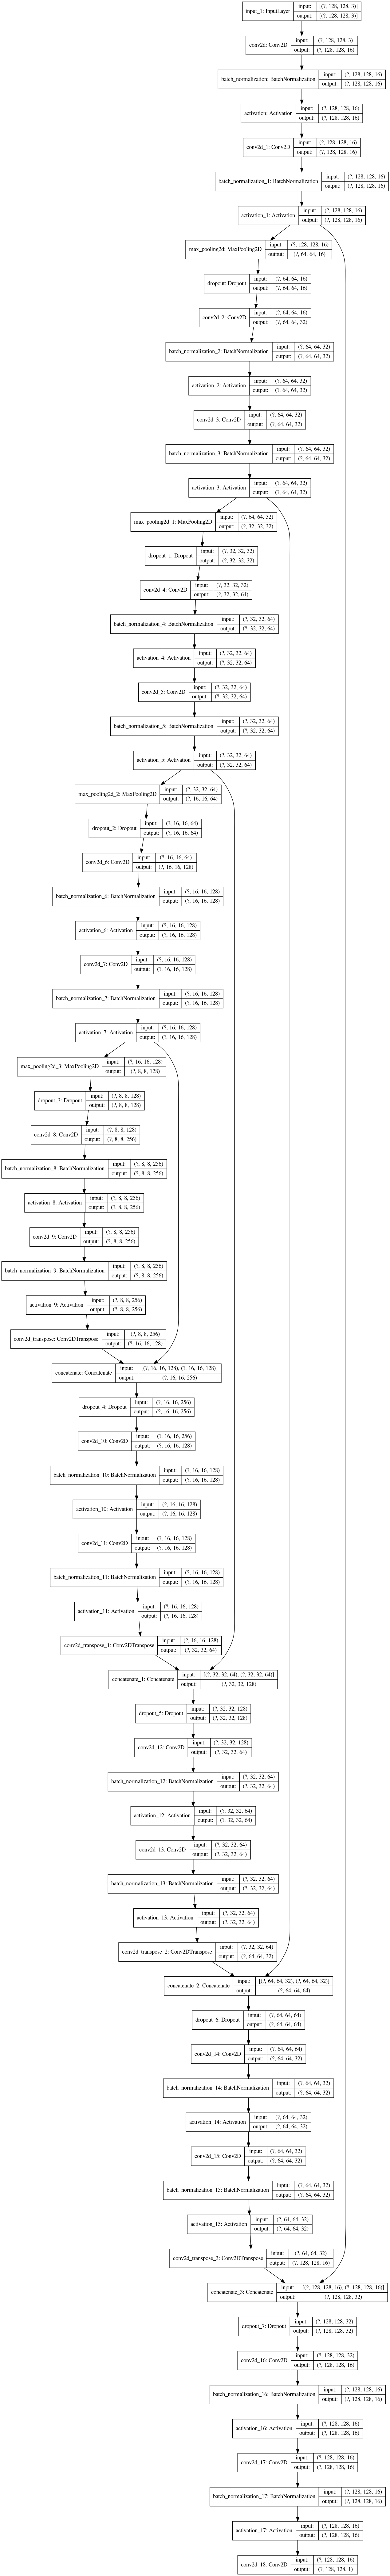

In [5]:
from keras.utils.vis_utils import plot_model # imports the plot_model function, which is used to create a visual representation of a Keras model's architecture
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True) #Generates a visual diagram of the unet model and saves it as an image.



In [6]:
# code loads and processes training data (images and their corresponding masks) using the previously defined LoadData function.
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 256)
#shape = 256:  Images and masks will be resized to 256×256 pixels during processing.
#This processed dataset (framObjTrain) can now be used for training a segmentation model (e.g., U-Net) on the
#road extraction task. The images (framObjTrain['img']) are input data,
#and the masks (framObjTrain['mask']) serve as labels for supervised learning.

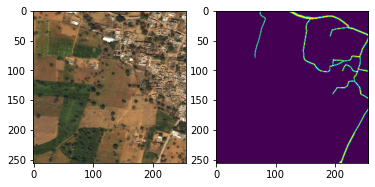

In [7]:
## displaying data loaded by our function
#to visualize an image and its corresponding mask from the dataset (framObjTrain) side by side using matplotlib.
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [8]:
#Starts the training process for the unet model.fit method adjusts the model's weights to minimize the specified loss function (binary_crossentropy) using the training data over multiple iterations (epochs).
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 40, verbose = 1)
#verbose = 1 means progress bars and metrics (e.g., loss, accuracy) will be printed during training.

Epoch 1/40
195/195 [==============================] - 40s 207ms/step - loss: 0.2068 - accuracy: 0.9486
Epoch 2/40
195/195 [==============================] - 40s 203ms/step - loss: 0.1389 - accuracy: 0.9538
Epoch 3/40
195/195 [==============================] - 40s 203ms/step - loss: 0.1150 - accuracy: 0.9570
Epoch 4/40
195/195 [==============================] - 40s 203ms/step - loss: 0.1003 - accuracy: 0.9603
Epoch 5/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0915 - accuracy: 0.9627
Epoch 6/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0854 - accuracy: 0.9645
Epoch 7/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0819 - accuracy: 0.9656
Epoch 8/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0788 - accuracy: 0.9664
Epoch 9/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0759 - accuracy: 0.9674
Epoch 10/40
195/195 [==============================] - 40s 203ms/step - l

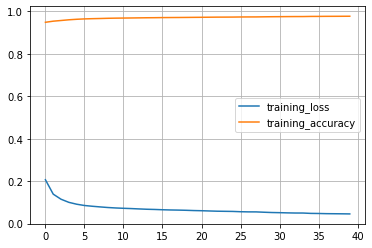

In [9]:
#This snippet visualizes the training loss and accuracy stored in the retVal variable after training the model.
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [10]:
#To predict the segmentation mask for 16 images using the trained model and return the predictions 
# alongside the input images and ground truth masks for evaluation or visualization.

def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16] #Extracts the first 16 images from the validation dataset stored in valMap['img']
    mask = valMap['mask'][0:16] #Extracts the first 16 ground truth masks from the validation dataset stored in valMap['mask'].
    #mask = mask[0:16]
    
    imgProc = img [0:16] #Redundant line that again extracts the same 16 images (can be removed without affecting the functionality).
    imgProc = np.array(img) #Converts the list of images into a NumPy array, ensuring compatibility with the model's input format.
    
    predictions = model.predict(imgProc) #Uses the trained model to predict segmentation masks for the processed images.
  
    #Returns the predicted masks (predictions), processed input images (imgProc), and corresponding ground truth masks (mask).
    return predictions, imgProc, mask 


#To visualize the original image, predicted segmentation mask, and ground truth mask side-by-side.
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9)) #Creates a figure with a size of 9x9 inches for plotting.
    
    plt.subplot(1,3,1) #Sets up the first subplot in a 1x3 grid for the original image.
    plt.imshow(img) #Displays the input aerial image in the first subplot.
    plt.title('Aerial image') #Sets the title of the first subplot to "Aerial image".
    
    plt.subplot(1,3,2) #Sets up the second subplot in the grid for the predicted mask.
    plt.imshow(predMask) #Displays the predicted segmentation mask in the second subplot.
    plt.title('Predicted Routes') #Title
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth) #Displays the ground truth mask in the third subplot.
    plt.title('Actual Routes') #Title
    
  

In [11]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)
#The U-Net model makes predictions for the first 16 images in the training dataset.
#These predictions (sixteenPrediction) are compared with the ground truth (masks) to visually or quantitatively evaluate the model's performance.
#predict16(framObjTrain, unet): ; unet: The trained U-Net model.
#sixteenPrediction:Stores the predicted segmentation masks generated by the model for the first 16 images in the dataset.
#actuals: Contains the original 16 images from framObjTrain['img']
#masks:Stores the corresponding ground truth segmentation masks from framObjTrain['mask']

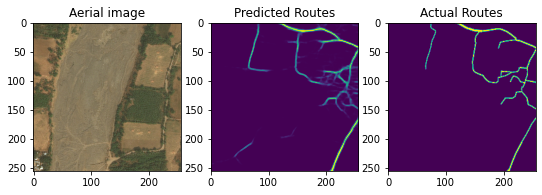

In [12]:
#to visualize the aerial image, predicted mask, and ground truth mask for the 12th image in the dataset
Plotter(actuals[12], sixteenPrediction[1][:,:,0], masks[1])

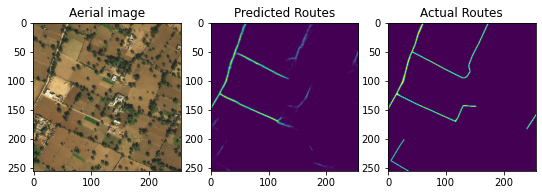

In [13]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

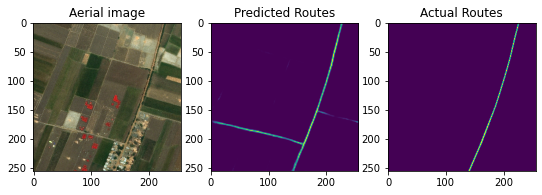

In [14]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

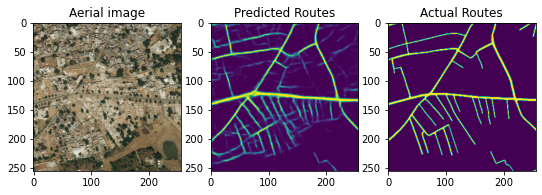

In [15]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

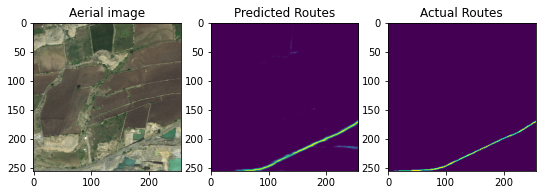

In [16]:
Plotter(actuals
        [11], sixteenPrediction[11][:,:,0], masks[11])

In [17]:
# Function to load test data (only aerial images, no masks)
def LoadTestData(imgPath, shape=256):
    imgNames = os.listdir(imgPath)
    imgAddr = imgPath + '/'
    
    testImgs = []
    
    # Load and preprocess images
    for imgName in imgNames:
        try:
            img = plt.imread(imgAddr + imgName)
        except:
            continue
        img = cv2.resize(img, (shape, shape))  # Resize to match the model input size
        testImgs.append(img)
        
    return np.array(testImgs)



In [18]:
# Function to make predictions and plot results
def PredictAndPlot(testImgs, model, shape=256):
    # Predicting the mask
    predictions = model.predict(testImgs)
    
    # Visualizing the results (for the first 5 test images)
    for i in range(min(5, len(testImgs))):  # Visualize up to 5 images
        plt.figure(figsize=(12, 4))
        
        # Original Image (Aerial Image)
        plt.subplot(1, 2, 1)
        plt.imshow(testImgs[i])
        plt.title('Original Aerial Image')

        # Predicted Mask (Segmentation result)
        plt.subplot(1, 2, 2)
        plt.imshow(predictions[i][:, :, 0], cmap='gray')  # Display mask in grayscale
        plt.title('Predicted Mask')

        plt.show()

In [ ]:
# Example usage
testImgPath = '/kaggle/input/deepglobe-road-extraction-dataset/test'  # Replace with your test image path

# Load the test data (only aerial images)
testImgs = LoadTestData(testImgPath, shape=256)

# Make predictions using the trained model
PredictAndPlot(testImgs[78], unet, shape=256)

In [24]:
unet.save('/kaggle/working/RouteGenerator_1.h5')

In [ ]:
print("TensorFlow Version:", tf.__version__)
